<a href="https://colab.research.google.com/github/xeqoir/Data-Science/blob/main/Unit2/YaleXieU2proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I: Context

For my project, I will be calculating whether Nvidia's stock price will go up or down on a given day. Nvidia is a technology company that "designs and supplies graphics processing units (GPUs), application programming interfaces (APIs) for data science and high-performance computing, as well as system on a chip units (SoCs) for the mobile computing and automotive market" (Wikipedia). Over the past year, Nvidia has seen monumental growth, and I'm interested in using data from the stock market to predict its future growth. For this model, I will be assuming that the probability that Nvidia's stock price going up is not affected by a previous day's performance and that the current situation will remain somewhat similar for the duration of the prediction.

In [1]:
!pip install preliz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.6/505.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.


In [2]:
import preliz as pz
import numpy as np
import arviz as az
import pymc as pm
import arviz as az

# Part II : Prior

I will first create a beta distribution for my **prior**. I am assuming, in my limited knowledge of the stock market, that the probability of the price of Nvidia's stock rising on a given day is a bit higher than 50%. I am **relatively certain**, but not overly certain, of this because I think that Nvidia is a promising company in a promising field with a good recent track record. For this reason, I'm using an alpha value of 27 and a beta value of 23 for a **54% chance** of Nvidia's stock price going up on a given day.

$p(θ) = Beta(α=27, β=23)$ (Arredondo)

(0.54, 0.5405375562695769, 0.5416666666666666)

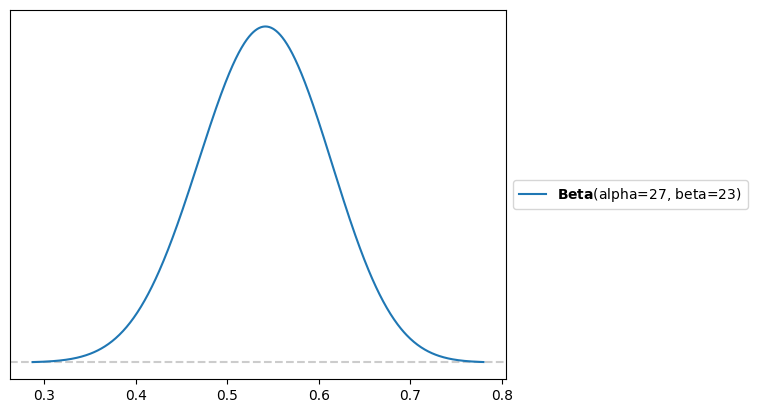

In [3]:
pz.Beta(alpha = 27, beta = 23).plot_pdf()
stockPrior = pz.Beta(alpha = 27, beta = 23)
stockPrior_mode = (stockPrior.alpha - 1)/(stockPrior.alpha + stockPrior.beta - 2)
stockPrior.mean(), stockPrior.median(), stockPrior_mode

# Part III: Likelihood

The above graph is the beta distribution for my prior. I also included the **mean, median, and mode**, which are the expected stock price increase percentage, middle stock price increase percentage, and most likely stock price increase percentage, respectively. Now, I'm going to make a **likelihood** using data I found from Yahoo Finance. I went through the past 3 months of market data on Nvidia and found that out of 64 days, 33 of those days saw Nvidia's stock price go up and the rest of the 31 days saw Nvidia's stock price go down. I will use a binomial distribution to represent this new data.

$p(y|θ) = Binomial(n=64, k=33, θ)$ (Arredondo)

<Axes: >

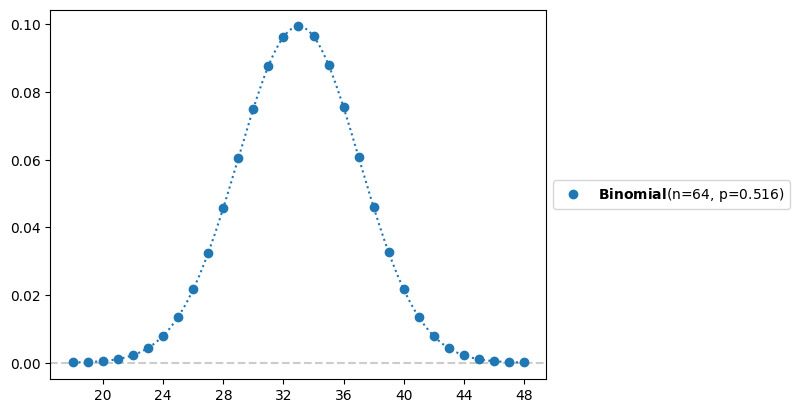

In [4]:
pz.Binomial(n = 64, p = 33/64).plot_pdf()

# Part IV: Posterior

The above graph shows the binomial distribution for my likelihood, meaning the probability that Nvidia's stock price going up 33 out of 64 days, given the true percentage of Nvidia's stock going up on a given day. Now, I will use both my prior and my likelihood to create a **posterior**, which is $p(θ|y)$.

$p(θ|y) ∝ p(y|θ)p(θ) = Beta(α_{new}=α+k, β_{new}=n-k+β)$ (Arredondo)

<Axes: >

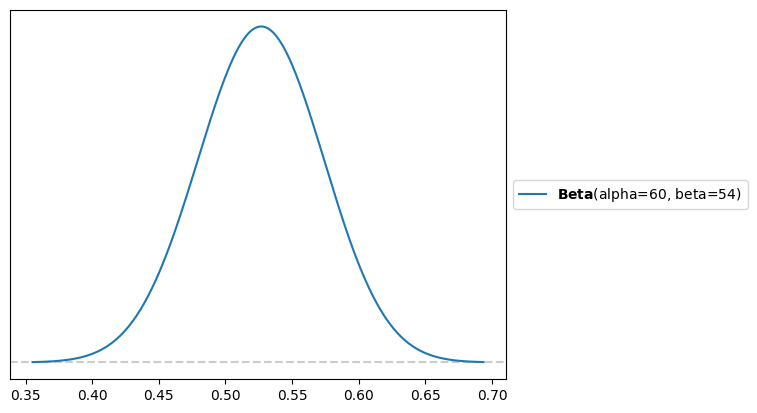

In [5]:
#prior info
alpha_old = 27
beta_old = 23

#likelihood info
k = 33 #days Nvidia's stock went up
n = 64 #total days tracked

analytic_stock = pz.Beta(alpha = alpha_old + k, beta = beta_old + n - k)
analytic_stock.plot_pdf()

The above graph is the beta distribution for my posterior (analytic). Now, I will use pymc to do another analysis. I will first create a **binary array** of length 64 (total number of days) with 33 1s and 31 0s (representing 33 stock price increases and 31 stock price decreases respectively) and store it in stock_data. Then, I will define the prior and likelihood using θ and y respectively before drawing 1,000 samples from the posterior. Finally, I will create a **pymc model** of the posterior and an **analytic model** of the posterior.

<Axes: title={'center': 'θ'}>

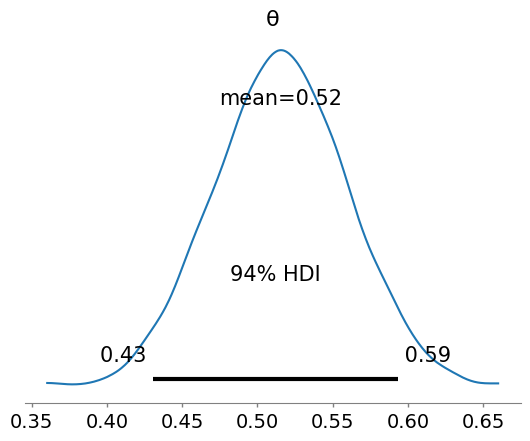

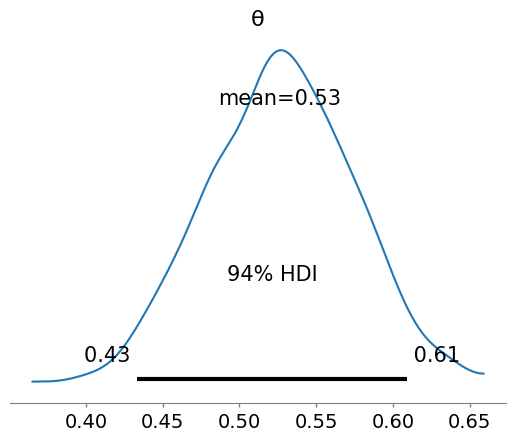

In [6]:
#the days Nvidia's stock price went up
stock_ups = np.repeat(1, 33)

#the days Nvidia's stock price went down
stock_downs = np.repeat(0, 31)

#combine ups and downs into one array
stock_data = np.concatenate( [stock_ups,stock_downs] )

with pm.Model() as stock_model:
  θ = pm.Beta('θ' , alpha = 33. , beta = 31.) # defining the prior
  y = pm.Bernoulli('y', p = θ, observed = stock_data) # defining the likelihood
  idata_stock = pm.sample(1000)

az.plot_posterior(idata_stock) #pymc model of the posterior
az.plot_posterior( {'θ' : analytic_stock.rvs(1000)} ) #analytic model of the posterior

# Part V: Conclusion

The above distributions show the **mean** (the expected stock price increase percentage) and the **HDI** (94% chance that the true probability of a stock price increase is between the left and right values shown). This is pretty similar to what I expected. My prior was 54% with relative certainty, which is essentially what is being represented on the two plots: the curves are not particularly wide, but not really compressed either, showing a moderate amount of uncertainty. The mean on the two plots are also very close to what I initially predicted with my prior.

Finally, I will create a **prediction** for a **set of 64 days** using pymc's sample posterior predictive function.

In [7]:
pm.sample_posterior_predictive(idata_stock, model=stock_model, extend_inferencedata=True)
stacked_stock = az.extract(idata_stock, group="posterior_predictive")
stacked_stock.sel(sample=0).sel(draw=0).y.to_series().values
# a prediction for the next 64 days where 0 means the stock price is expected to go down and 1 means the stock price is expected to go up

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0])

And we're finished! We've created graphs for the posterior using a pymc model and an analytic model and created a prediction for the next set of 64 days.